# Understanding L2 regularization, Weight decay and AdamW
> A post explaining L2 regularization, Weight decay and AdamW optimizer as described in the paper Decoupled Weight Decay Regularization we will also go over how to implement these using tensorflow2.x .

- toc: false
- badges: true
- comments: true
- categories: [machinelearning deeplearning python3.x tensorflow2.x]

## What is regularization ?

In simple words regularization helps in reduces over-fitting on the data. There are many regularization strategies.

The major regularization techniques used in practice are:
* L2 Regularization
* L1 Regularization
* Data Augmentation
* Dropout
* Early Stopping

## L2 regularization :

In L2 regularization, an extra term often referred to as regularization term is added to the loss function of the network.
 
Consider the the following cross entropy loss function (without regularization): 

$$loss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) $$

To apply L2 regularization to the loss function above we add the term given below to the loss function :

$$\frac{\lambda}{2m}\sum\limits_{w}w^{2} $$

where $\lambda$ is a hyperparameter of the model known as the regularization parameter. $\lambda$ is a hyper-parameter which means it is not learned during the training but is tuned by the user manually

After applying the `regularization term` to our original loss function :
$$finalLoss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) + \frac{\lambda}{2m}\sum\limits_{w}w^{2}$$

or , 
$$ finalLoss = loss+ \frac{\lambda}{2m}\sum\limits_{w}w^{2}$$


or in simple code :


```python
final_loss = loss_fn(y, y_hat) + lamdba * np.sum(np.pow(weights, 2)) / 2
final_loss = loss_fn(y, y_hat) + lamdba * l2_reg_term 
```

> Note: all code equations are written in python, numpy notation.

Cosequently the weight update step for **vanilla SGD** is going to look something like this:
```python
w = w - learning_rate * grad_w - learning_rate * lamdba * grad(l2_reg_term, w)
w = w - learning_rate * grad_w - learning_rate * lamdba * w
```

> Note: assume that grad_w is the gradients of the loss of the model wrt weights of the model.

> Note: assume that grad(a,b) calculates the gradients of a wrt to b.

In major deep-learning libraires L2 regularization is implemented by by adding `lamdba * w` to the gradients, rather than actually changing the loss function.

```python
# compute the gradients to update w
# grad_w is the gradients of loss wrt to w
gradients = grad_w + lamdba * w
# update step
w = w - learning_rate * gradients
```

## Weight Decay :

In weight decay we do not modify the loss function, the loss function remains the instead instead we modfy the update step :


The loss remains the same :

```python
final_loss = loss_fn(y, y_hat)
```

During the update parameters :

```python
w = w - learing_rate * grad_w - learning_rate * lamdba * w
```

> Tip: The major difference between **L2 regularization** & **weight decay** is while the former modifies the gradients to add `lamdba * w` , **weight decay** does not modify the gradients but instead it subtracts `learning_rate * lamdba * w` from the weights in the update step. 

A **weight decay** update is going to look like this :

```python
# compute the gradients to update w
# grad_w is the gradients of loss wrt to w
gradients = grad_w
# update step
w = w - learning_rate * gradients - learning_rate * lamdba * w
```

In this equation we see how we subtract a little portion of the weight at each step, hence the name decay.

> Important: From the above equations **weight decay** and **L2 regularization** may seem the same and it is infact same for **vanilla SGD** , but as soon as we add momentum, or use a more sophisticated optimizer **like Adam**, **L2 regularization** and **weight decay** become different.

## Weight Decay != L2 regularization

### SGD with Momentum :

To prove this point let's first take a look at **SGD with momentum**

In **SGD with momentum** the gradients are not directly subtracted from the weights in the update step. 
* First, we calculate a `moving average` of the gradients .
* and then , we subtract the `moving average` from the weights.

For L2 regularization the steps will be : 

```python
# compute gradients 
gradients = grad_w + lamdba * w
# compute the moving average
Vdw = beta * Vdw + (1-beta) * (gradients)
# update the weights of the model
w = w - learning_rate * Vdw
```

Now, weight decay’s update will look like

```python
# compute gradients 
gradients = grad_w
# compute the moving average
Vdw = beta * Vdw + (1-beta) * (gradients)
# update the weights of the model
w = w - learning_rate * Vdw - learning_rate * lamdba * w
```

> Note: $Vdw$ is a moving average of the parameter w . It starts at 0 and then at each step it is updated using the formulae for $Vdw$ given above. `beta` is a hyperparameter .

### Adam :

This difference is much more visible when using the **Adam** Optimizer. Adam computes adaptive learning rates for each parameter. Adam stores `moving average of past squared gradients` and `moving average of past gradients`. These `moving averages` of past and past squared gradients $Sdw$ and $Vdw$ are computed as follows: 

```python
Vdw = beta1 * Vdw + (1-beta1) * (gradients)
```

```python
Sdw = beta2 * Sdw + (1-beta2) * np.square(gradients)
```

> Note: similar to SGD with momentum $Vdw$ and $Sdw$ are moving averages of the parameter w. These moving averages start from 0 and at each step are updated with the formulaes given above. `beta1` and `beta2` are hyperparameters.

and the update step is computed as :
    
```python
w = w - learning_rate * ( Vdw/(np.sqrt(Sdw) + eps) )
```

> Note: `eps` is a hypermarameter added for numerical stability. Commomly,  $eps = 1e-08$ . 

For L2 regularization the steps will be :

```python
# compute gradients and moving_avg 
gradients = grad_w + lamdba * w

Vdw = beta1 * Vdw + (1-beta1) * (gradients)
Sdw = beta2 * Sdw + (1-beta2) * np.square(gradients)

# update the parameters
w = w - learning_rate * ( Vdw/(np.sqrt(Sdw) + eps) )
```


For weight-decay the steps will be :

```python
# compute gradients and moving_avg 
gradients = grad_w

Vdw = beta1 * Vdw + (1-beta1) * (gradients)
Sdw = beta2 * Sdw + (1-beta2) * np.square(gradients)

# update the parameters
w = w - learning_rate * ( Vdw/(np.sqrt(Sdw) + eps) ) - learning_rate * lamdba * w
```

The difference between **L2 regularization** and **weight decay** is clearly visible now.

In the case of **L2 regularization** we add this `lamdba * w` to the gradients then compute a moving average of the gradients and their squares before using both of them for the update. 

Whereas the **weight decay** method simply consists in doing the update, then subtract to each weight.


After much experimentation Ilya Loshchilov and Frank Hutter suggest in their paper : [DECOUPLED WEIGHT DECAY REGULARIZATION](https://arxiv.org/pdf/1711.05101.pdf) we should use weight decay with **Adam**, and not the L2 regularization that classic deep learning libraries implement. This is what gave rise to **AdamW**.

In simple terms, **AdamW** is simply **Adam** optimzer used with **weight decay** instead of classic **L2 regularization**.

## Implementing L2 regularization, weight decay and AdamW :

Now that we have got the boring theory part out of the way. Let's look at how implement L2 regularization, weight decay and AdamW can be implemented in **Tensorflow2.X** . 

For this part we are going to use these libraries : 
* [TensorFlow](https://www.tensorflow.org/)
* [TensorFlow Addons](https://www.tensorflow.org/addons)
* [TensorFlow Datasets](https://www.tensorflow.org/datasets)

### Setting up imports

In [92]:
#hide_input
import warnings
import logging

warnings.filterwarnings("ignore")
%matplotlib inline

In [93]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


AUTOTUNE = tf.data.experimental.AUTOTUNE

### Loading and pre-preocessing the data :

**In this example we are going to use the `tf_flowers` dataset available in tensorflow datasets**

In [94]:
# load in the datasets

# train dataset
train_ds = tfds.load("tf_flowers", 
                     split="train[:80%]",
                     as_supervised=True, 
                     with_info=False
                    )


# validation dataset
valid_ds = tfds.load("tf_flowers", 
                     split="train[80%:]",
                     as_supervised=True, 
                     with_info=False)

print("NUM EXMAPLES IN TRAIN DATASET     : ", len(train_ds))
print("NUM EXAMPLES IN VALIDATION DATASET: ", len(valid_ds))

NUM EXMAPLES IN TRAIN DATASET     :  2936
NUM EXAMPLES IN VALIDATION DATASET:  734


In [95]:
IMAGE_SIZE = 120


def process_image(image, label, img_size=IMAGE_SIZE):
    """
    Fn converts the images data types, scales to image to have pixel
    values betwwen [0, 1] 
    This functions also resizes the image to given `img_size`.
    
    Args:
        image   : An image
        label   : target label associated with the image
        img_size: size of the image after resize
    """
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

In [96]:
# Process the dataset into the format tensorflow expects the
# dataset to be

train_ds = train_ds.map(process_image, num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)

valid_ds = valid_ds.map(process_image, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

**View images from the dataset :**

In [97]:
#collapse
def view_images(ds):
    """
    Diplays images from the given dataset
    
    Args:
        ds: A TensorFlow Dataset
    """
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(10,10))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

> **Train dataset :**

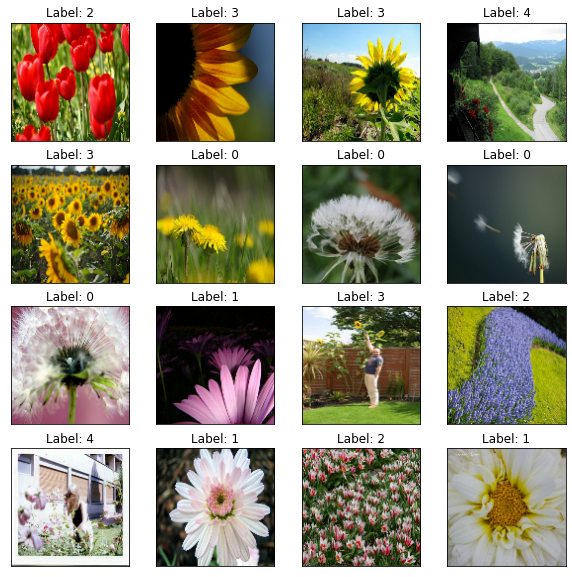

In [98]:
#collapse

# view example images from the train dataset
view_images(train_ds)

> **Validation dataset :**

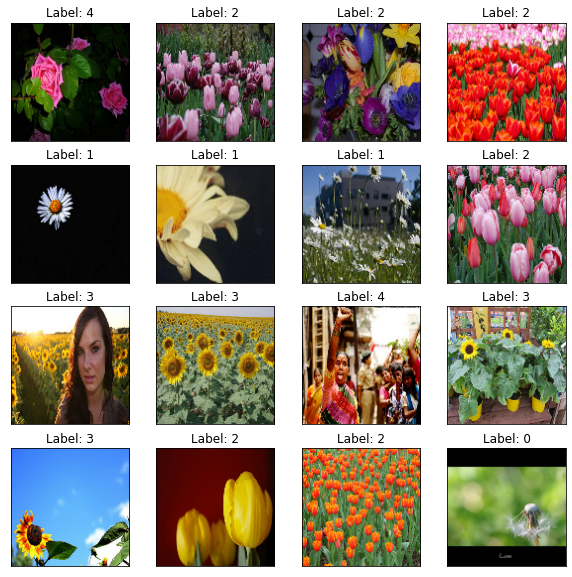

In [99]:
#collapse


# view example images from the valid dataset
view_images(valid_ds)

### L2 regularization :

To use L2 regularization, in tensorflow we need to use the class : `tf.keras.regularizers.L2` .

After which in each layer of our model we will need to add the argument `kernel_regularizer`.

Let's see and exmple below

**Build a model with  L2 regularization**

In [ ]:
# instantiate the l2 regularization class
# we also need to set the value from lambda in the 
# tf.keras.regularizers.l2 this values is passed to l2

l2_reg = tf.keras.regularizers.l2(l2=0.01)


def get_l2_model():
    """
    Returns a tf.keras.Model instance with L2 regularization .
    """
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        tf.keras.layers.Conv2D(64, 3, kernel_regularizer=l2_reg, padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(64, 3, kernel_regularizer=l2_reg, padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5), # since our data has five distinct classes
        tf.keras.layers.Activation("softmax"),
    ])
    return model

**L2 regularizaton with SGD and momentum :**

In [ ]:
# Specify the model optimizer, loss_fn and metrics
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=1e-03, momentum=0.9)
LOSS_FN   = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS   = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

model = get_l2_model()
model.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=METRICS)


# Fit model on the train data
l2_sgd_hist = model.fit(train_ds, validation_data=valid_ds, epochs=40)

**L2 regularization with Adam :**

In [ ]:
# Specify the model optimizer, loss_fn and metrics
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=1e-03,)
LOSS_FN   = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS   = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

model = get_l2_model()
model.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=METRICS)


# Fit model on the train data
l2_adam_hist = model.fit(train_ds, validation_data=valid_ds, epochs=40)

## Weight Decay :

To use SGD with momentum along with weight_decay we need to use the class : `tfa.optimizers.SGDW`.

This class implements the SGDW optimizer described in [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101) by Loshchilov & Hutter.

In [ ]:
# instantiate model to use with the weight decay optimizers

def get_wd_model():
    """
    Returns a tf.keras.Model instance without L2 regularization.
    """
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        tf.keras.layers.Conv2D(64, 3, padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(64, 3, padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5), # since our data has five distinct classes
        tf.keras.layers.Activation("softmax"),
    ])
    return model

In [ ]:
# instantiate model
model = get_wd_model()

# instantiate model with SGD with WD optimizer
OPTIMZER = tfa.optimizers.SGDW(weight_decay=1e-04, learning_rate=1e-03, momentum=0.9)
model.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=METRICS)

# Fit model on the train data
wd_sgd_hist = model.fit(train_ds, validation_data=valid_ds, epochs=40)

## AdamW :

To use AdamW optimizer we need to use the class : `tfa.optimizers.AdamW`

This is an implementation of the AdamW optimizer described in [Decoupled Weight Decay Regularization](https://arxiv.org/pdf/1711.05101.pdf) by Loshch ilov & Hutter.

In [ ]:
# instante model
model = get_wd_model()

# instantite model AdamW Optimizer
OPTIMZER = tfa.optimizers.AdamW(weight_decay=1e-04, learning_rate=1e-03)

# Fit model on the train data
adamW_hist = model.fit(train_ds, validation_data=valid_ds, epochs=40)